In [27]:
import pandas as pd
import numpy as np

%matplotlib inline

In [28]:
# read in all the data
ratings_dtype = {
    'tconst': str,
    'averageRating': float,
    'numVotes': int
}

ratings = pd.read_csv('./title.ratings.tsv.gz', sep='\t', header=0, dtype=ratings_dtype)

principals_dtype = {
    'tconst': str,
    'principalCast': object
}

principals = pd.read_csv('./title.principals.tsv.gz', sep='\t', header=0, dtype=principals_dtype)

basics_dtype = {
    'tconst': str,
    'titleType': str,
    'primaryTitle': str,
    'originalTitle': str,
    'isAdult': int,
    'startYear': str,
    'endYear': str,
    'runtimeMinutes': object,
    'genres': str
}

basics = pd.read_csv('./title.basics.tsv.gz', sep='\t', header=0, dtype=basics_dtype)

In [5]:
# just take the three top-billed principals of the movie and delete columns we don't need
principals =  principals[principals['ordering'] <= 3]
principals =  principals[['tconst', 'ordering', 'nconst']]

In [6]:
# extract tv-series
series  =  basics[basics['titleType'] == 'tvSeries']
series = series[['tconst']]

In [7]:
data = pd.merge(series, pd.merge(ratings, principals), how='inner')

In [8]:
data.head()

,tconst,averageRating,numVotes,ordering,nconst
0,tt0039120,3.7,6,1,nm0113897
1,tt0039120,3.7,6,2,nm0274631
2,tt0039120,3.7,6,3,nm0240118
3,tt0039123,8.5,108,1,nm0853299
4,tt0039123,8.5,108,2,nm0379051


In [9]:
# in how many series does the principal attend (relating to this dataset)
# I suppose that a principal, wich takes part in many series is more important -> how does the importance have impact on rating of series
data['principalCount'] = pd.Series(np.zeros(data.shape[0]))
# what's the average rating of the films with this pricipal (relating to this dataset)
data['principalAverageRating'] = pd.Series(np.zeros(data.shape[0]))

In [10]:
principalDict = data['nconst'].value_counts().to_dict()

In [13]:
sumAverageRatingDict = {}

In [14]:
data = data.sort_values(by=['nconst'])

In [22]:
# iterate over dataframe "data" and fill dictionary "sumAverageRatingDict" with sum of average rating of series with this principal
for i, line in data.iterrows():
    value = line['nconst']
    if value in sumAverageRatingDict:
        rating = sumAverageRatingDict[value]
        sumAverageRatingDict[value] = rating + line['averageRating']
    else:
        sumAverageRatingDict[value] = line['averageRating']

In [23]:
# fill the new columns of the dataset
for i, line in data.iterrows():
    value = line['nconst']
    data.set_value(i, 'principalCount', principalDict[value])
    ave = sumAverageRatingDict[value] / principalDict[value]
    data.set_value(i, 'principalAverageRating', ave)

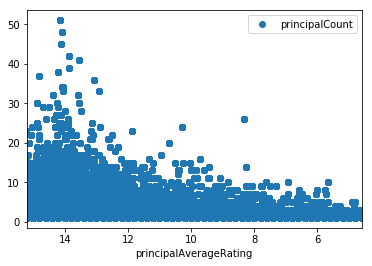

In [26]:
data.plot(x='principalAverageRating', y='principalCount', style='o')

### seems like series with more important principals are higher rated